In [ ]:
# Exercise 2 (Lab 4)

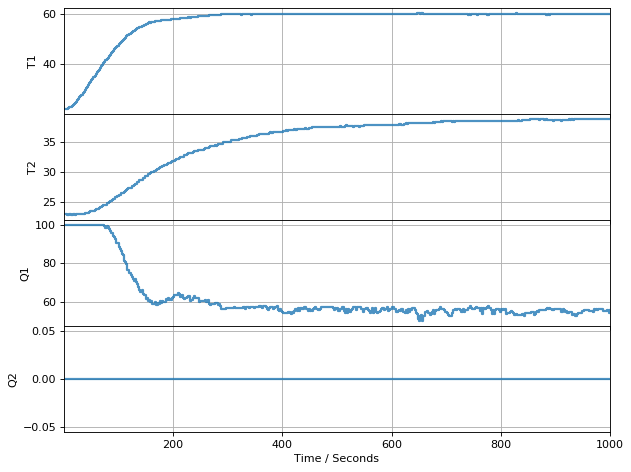

TCLab disconnected successfully.


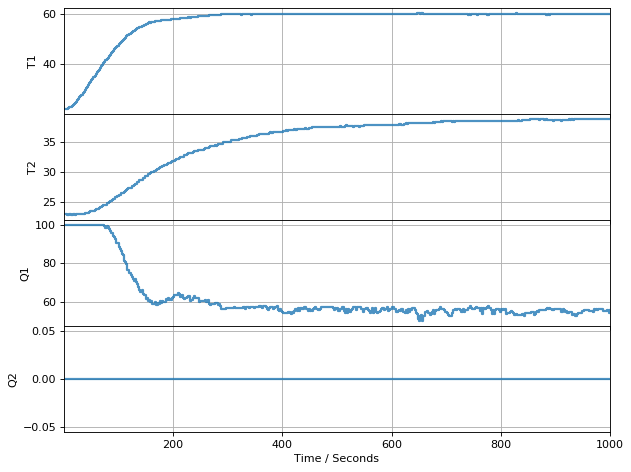

In [13]:
# Verify performance of the inner controller to a step change in setpoint. 
# You're looking for a step response with minimal or no overshoot of the setpoint. 

# This step response occurs without a disturbance from heater 2

# PI controller from Lab 3 (with anti-integral windup)

%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup


# add anti-integral windup feature

def PI_antiwindup(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        t_step, SP, PV, MV = yield MV   # <==== now gets MV from experiment
        e = PV - SP
        MV += -Kp*(e - e_prev) - t_step*Ki*e 
        MV = max(MV_min, min(MV_max, MV)) # <==== range limits
        e_prev = e


# final time and time step
t_final = 1000
t_step = 5

# perform experiment

# create a function that introduces the setpoint but with NO disturbance
def experiment(controller, t_final, t_step=5,
               SP=lambda t: 60, # step change in SP occurs at time 0 (goes from T_amb to 60)
               DV=lambda t: 0): # no disturbance occurs
    
    TCLab = setup(connected=True)
    with TCLab() as lab:
        
        lab.P1 = 255
        lab.P2 = 50
        
        h = Historian(lab.sources)
        p = Plotter(h, t_final)
        for t in clock(t_final):
            T1 = lab.T1
            U1 = lab.Q1()                           
            U1 = controller.send((t_step, SP(t), T1, U1))   
            lab.Q1(U1)

            p.update(t)  
    h.to_csv('lab4_ex2_step_change_2.csv')
    
# control parameters

controller = PI_antiwindup(10.0, 0.06, MV_bar=0,MV_min=0, MV_max=100) 

# manipulate Kp/Ki here to get the right response - these are the inner loop gains

controller.send(None)

experiment(controller,t_final,t_step)


# step test completed without a disturbance!!! then fit the model

In [14]:
# Read data into panda dataframe

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

# read data file from the Github repository into a Pandas dataframe
data_location = "lab4_ex2_step_change_2.csv"
expt = pd.read_csv(data_location)

# set time index
expt = expt.set_index("Time")
t_expt = expt.index

# display data in tabular format
display(expt)


,T1,T2,Q1,Q2
Time,,,,
0.00,22.091,22.832,100.000,0.0
2.01,22.155,22.832,100.000,0.0
4.01,22.155,22.832,100.000,0.0
6.01,22.188,22.768,100.000,0.0
8.01,22.478,22.768,100.000,0.0
...,...,...,...,...
992.02,60.021,38.945,55.508,0.0
994.01,60.183,38.945,55.841,0.0
996.01,60.021,38.945,55.195,0.0


In [15]:
# create a function to compare two data sets
def plot_data(expt, pred):
    t_expt = expt.index
    
    # create a 3 x 1 grid of plot axes
    fig, ax = plt.subplots(3, 1, figsize=(10,8))
    
    # first plot axes
    ax[0].scatter(t_expt, expt["T1"], label="T1 expt")
    ax[0].scatter(t_expt, expt["T2"], label="T2 expt")
    ax[0].plot(t_expt, pred["T1"], label="T1 pred")
    ax[0].plot(t_expt, pred["T2"], label="T2 pred")
    ax[0].set_ylabel("deg. C.")
    ax[0].set_title("Temperature Response")

    # second plot axes
    ax[1].scatter(t_expt, expt["Q1"], label="Q1 expt")
    ax[1].scatter(t_expt, expt["Q2"], label="Q2 expt")
    ax[1].plot(t_expt, pred["Q1"], label="Q1 pred")
    ax[1].plot(t_expt, pred["Q2"], label="Q2 pred")
    ax[1].set_ylim([0, 100])
    ax[1].set_ylabel("Percent")
    ax[1].set_title("Heater Power")
    
    # third plot axes
    ax[2].plot(t_expt, pred["T1"]-expt["T1"], label="T1 error")
    ax[2].plot(t_expt, pred["T2"]-expt["T2"], label="T1 error")
    ax[2].set_title("Residuals")
    
    # things to do for every plot axes
    for a in ax:
        a.grid(True)
        a.set_xlabel("time / seconds")
        a.legend()
        
    plt.tight_layout()
    
    return


Time
0.00      -0.832000
2.01      -0.832000
4.01      -0.832000
6.01      -0.768000
8.01      -0.768000
             ...   
992.02     0.080135
994.01     0.080986
996.01     0.081832
998.01     0.082669
1000.01    0.083495
Name: T2, Length: 501, dtype: float64

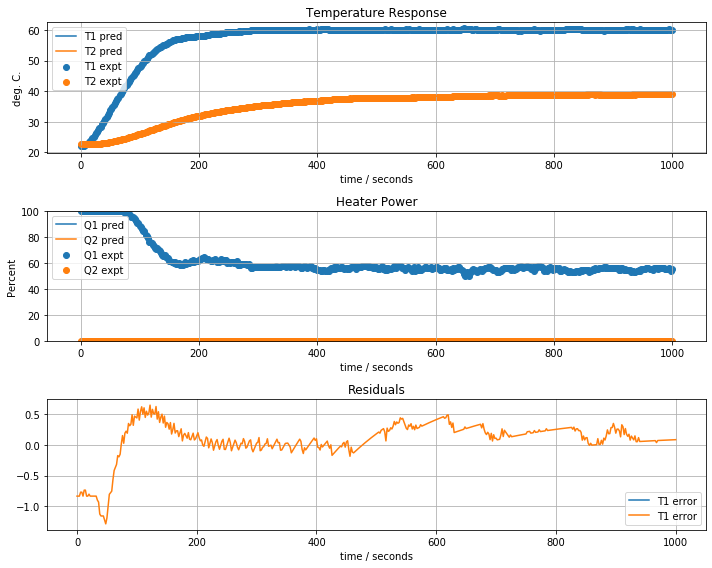

In [18]:
# FIRST ORDER PLUS DEAD TIME (FOPDT) - use this to model T2 for the outer controller

# parameter values and units
T_amb = 22                 # deg C
u1bar = 60 - T_amb # magnitude of step change of setpoint 1
t_expt = expt.index

# adjustable parameters
K = 0.45
tau = 174
t_delay = 47

def model_first_order_delay(param, plot=False):
    K, tau, t_delay = param
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T2"] = [T_amb + K*u1bar*(1 - np.exp(-(t-t_delay)/tau)) if t > t_delay else T_amb for t in t_expt] # u1 bar is the magnitude of step change
    if plot:
        plot_data(expt, pred)
    return pred["T2"] - expt["T2"]
    
model_first_order_delay([K, tau, t_delay], True)

K = 0.44568626241729115,  tau = 174.30564740016004, time delay = 46.92637395901079


Time
0.00      -0.832000
2.01      -0.832000
4.01      -0.832000
6.01      -0.768000
8.01      -0.768000
             ...   
992.02    -0.083747
994.01    -0.082898
996.01    -0.082054
998.01    -0.081219
1000.01   -0.080395
Name: T2, Length: 501, dtype: float64

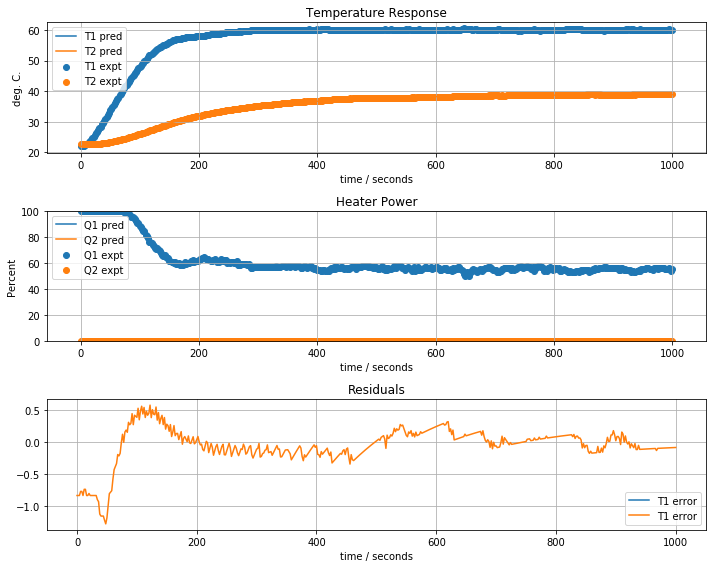

In [17]:
# Use least squares fit
results = least_squares(model_first_order_delay,  [K, tau, t_delay])
K, tau, t_delay = results.x
print(f"K = {K},  tau = {tau}, time delay = {t_delay}")
model_first_order_delay(results.x, True)

In [6]:
# Estimate the time constant and dead time to a step change in setpoint. 

time_cst = 174.3056
t_delay = 46.926
print('An estimate of the time constant of a step change in setpoint is:',time_cst,'seconds.')
print('An estimate of the dead time to a step change in setpoint is:',t_delay,'seconds.')

An estimate of the time constant of a step change in setpoint is: 169.4354 seconds.
An estimate of the dead time to a step change in setpoint is: 45.15656 seconds.


In [19]:
# Need a step-test to determine the outer controller parameters (using the inner controller)

# Using empirical tuning rules, estimate proportional and integral gains for outer PI controller.
# Used the ITAE Tuning tuning rules (see Notebook 3.5) to estimate values for the PI control parameters 𝐾𝑃  and  𝐾𝐼 .

# From the inner loop response of T2:

gain = 0.445686

Kp_val = (0.586/gain)*(t_delay/time_cst)**-0.916
print('The estimated value for proportional gain, Kp, is:',round(Kp_val,5))

Ki_val = ((1.03-0.165*(t_delay/time_cst))/time_cst)*Kp_val
print('The estimated value for integral gain, Ki, is:',round(Ki_val,5))


The estimated value for proportional gain, Kp, is: 4.25593
The estimated value for integral gain, Ki, is: 0.02472


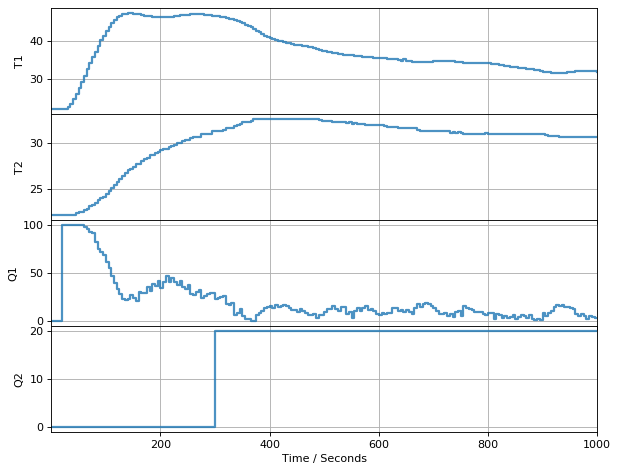

TCLab disconnected successfully.


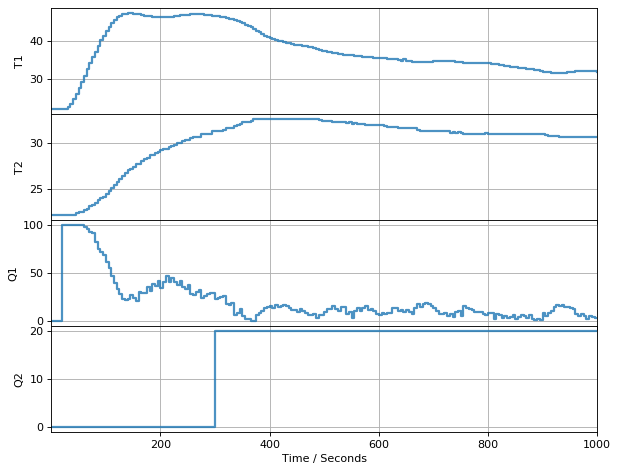

In [20]:
# For the cascade control loop, perform the same testing as you did for the first exercise. 
# Does cascade control improve closed response with respect to setpoint tracking? 
# With respect to disturbance rejection? Explain what you see.


# add anti-integral windup feature (added in again)

def PI_antiwindup_2(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):  
    MV = MV_bar
    e_prev = 0
    while True:
        t_step, SP, PV, MV = yield MV   # <==== now gets MV from experiment
        e = PV - SP
        MV += -Kp*(e - e_prev) - t_step*Ki*e 
        MV = max(MV_min, min(MV_max, MV)) # <==== range limits
        e_prev = e
        
        
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

# Set parameters
t_final = 1000
t_step = 5

T_amb = 22

# Set the proportional/integral gain values (calculated from the step change response in part 1)
Kp_inner = 10
Ki_inner = 0.06

# Outer proportiona/integral gain values (calculated using tuning rules from inner loop response values)
Kp_outer = 4.25593
Ki_outer = 0.02472


# create a function that introduces the setpoint and the disturbance
def experiment_2(inner_control,outer_control, t_final, t_step,
               SP2=lambda t: 30 if t >= 20 else 0, 
               DV=lambda t: 20 if t >= 300 else 0):


    TCLab = setup(connected=True)
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variables
        lab.P1 = 255
        lab.P2 = 50
        
        # create instances of the controllers
        next(inner_control)
        SP1 = next(outer_control) # initializes SP1 (outer control gives the first value of SP1)

    
        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            T2 = lab.T2
            U1 = lab.Q1()                            # <==== new line
            
            SP1 = outer_control.send((t_step,SP2(t), T2, SP1))     
            U1 = inner_control.send((t_step, SP1, T1, U1))    
            
            lab.Q1(U1) 
            lab.Q2(DV(t)) # <==== disturbance
            p.update(t)  
            
        h.to_csv('lab4_exercise2_cascade_2.csv')

        
# create two controllers
inner_control = PI_antiwindup(Kp_inner,Ki_inner,MV_min=0,MV_max=100)
# inner control MV is heater 1 power
outer_control = PI_antiwindup(Kp_outer,Ki_outer,MV_min=T_amb,MV_max=80)
# outer control MV is SP1 for inner control

# call the experiment
experiment_2(inner_control,outer_control,t_final,t_step)


In [ ]:
# For the cascade control loop, perform the same testing as you did for the first exercise. 
# Does cascade control improve closed response with respect to setpoint tracking? 
# With respect to disturbance rejection. Explain what you see.

# In this case, the cascade control improved the closed response with respect to setpoint tracking because it gave less of an overshoot of the
# setpoint temperature by T2 in comparison to exercise 1, however it took longer to reach near the setpoint and didn't fully reach to 30 degrees.

# For this trial, the cascade response did worse than exercise 1's control with respect to disturbance rejection because once the disturbance of 
# heater 2 was introduced at 300 seconds, the temperature of T2 continued to rise. 